# Predicting Tomorrow's CVS stock price prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Collect and prepare data for analysis

In [3]:
df = pd.read_csv('CVS.csv',  parse_dates=True)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df = df[['Close']]  # watch the spaces in the column name 

In [6]:
df

,Close
0,65.680000
1,66.599998
2,67.730003
3,68.690002
4,69.949997
...,...
1253,74.699997
1254,75.800003
1255,76.139999
1256,74.209999


In [7]:
df['Close'].isna().sum()

0

In [8]:
row_count = df.shape[0] # store the number of obersvations (daily temperature readings)
row_count

1258

In [9]:
temps = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
temps.shape

(1258, 1)

In [10]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [11]:
temps = temps[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
temps.shape

(1250, 1)

In [12]:
temps = temps.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
temps

array([[62.27    , 63.099998, 61.75    , ..., 66.82    , 65.839996,
        66.129997],
       [65.760002, 64.919998, 65.5     , ..., 64.800003, 65.989998,
        63.389999],
       [64.07    , 64.099998, 63.330002, ..., 66.349998, 68.410004,
        69.120003],
       ...,
       [77.      , 77.099998, 76.279999, ..., 74.980003, 75.559998,
        74.410004],
       [72.370003, 73.260002, 73.57    , ..., 76.089996, 76.25    ,
        77.75    ],
       [77.540001, 76.040001, 76.290001, ..., 76.139999, 74.209999,
        73.25    ]])

In [13]:
# we can now see that our days have been organized into rows of sequence length. 

In [14]:
# create our X and y. 
# X will be the 59 days prior...
X = temps[:, :-1] # all rows, all columns except the last one
# y will be the 60th day (what we are trying to predict)
y = temps[:, -1] # all rows, only the last column

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(87, 9, 1)
(38, 9, 1)


# RNN

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
3/3 [==============================] - 1s 130ms/step - loss: 6528.8032 - root_mean_squared_error: 80.8010 - val_loss: 6372.7549 - val_root_mean_squared_error: 79.8295
Epoch 2/600
3/3 [==============================] - 0s 19ms/step - loss: 6484.5747 - root_mean_squared_error: 80.5269 - val_loss: 6325.1367 - val_root_mean_squared_error: 79.5307
Epoch 3/600
3/3 [==============================] - 0s 14ms/step - loss: 6433.7393 - root_mean_squared_error: 80.2106 - val_loss: 6268.7397 - val_root_mean_squared_error: 79.1754
Epoch 4/600
3/3 [==============================] - 0s 15ms/step - loss: 6375.9678 - root_mean_squared_error: 79.8497 - val_loss: 6208.2852 - val_root_mean_squared_error: 78.7927
Epoch 5/600
3/3 [==============================] - 0s 16ms/step - loss: 6313.7637 - root_mean_squared_error: 79.4592 - val_loss: 6144.1431 - val_root_mean_squared_error: 78.3846
Epoch 6/600
3/3 [==============================] - 0s 18ms/step - loss: 6248.9600 - root_mean_squared_error: 

Epoch 47/600
3/3 [==============================] - 0s 18ms/step - loss: 4422.8237 - root_mean_squared_error: 66.5043 - val_loss: 4300.3477 - val_root_mean_squared_error: 65.5770
Epoch 48/600
3/3 [==============================] - 0s 18ms/step - loss: 4399.1299 - root_mean_squared_error: 66.3259 - val_loss: 4277.0161 - val_root_mean_squared_error: 65.3989
Epoch 49/600
3/3 [==============================] - 0s 16ms/step - loss: 4375.4111 - root_mean_squared_error: 66.1469 - val_loss: 4253.7207 - val_root_mean_squared_error: 65.2206
Epoch 50/600
3/3 [==============================] - 0s 18ms/step - loss: 4351.9722 - root_mean_squared_error: 65.9695 - val_loss: 4230.4697 - val_root_mean_squared_error: 65.0421
Epoch 51/600
3/3 [==============================] - 0s 18ms/step - loss: 4328.5449 - root_mean_squared_error: 65.7917 - val_loss: 4207.3921 - val_root_mean_squared_error: 64.8644
Epoch 52/600
3/3 [==============================] - 0s 18ms/step - loss: 4305.3672 - root_mean_squared_er

Epoch 93/600
3/3 [==============================] - 0s 16ms/step - loss: 3434.3926 - root_mean_squared_error: 58.6037 - val_loss: 3325.5635 - val_root_mean_squared_error: 57.6677
Epoch 94/600
3/3 [==============================] - 0s 17ms/step - loss: 3414.9224 - root_mean_squared_error: 58.4373 - val_loss: 3306.4951 - val_root_mean_squared_error: 57.5021
Epoch 95/600
3/3 [==============================] - 0s 18ms/step - loss: 3395.7996 - root_mean_squared_error: 58.2735 - val_loss: 3287.5610 - val_root_mean_squared_error: 57.3373
Epoch 96/600
3/3 [==============================] - 0s 16ms/step - loss: 3376.7400 - root_mean_squared_error: 58.1097 - val_loss: 3268.7703 - val_root_mean_squared_error: 57.1732
Epoch 97/600
3/3 [==============================] - 0s 16ms/step - loss: 3357.6965 - root_mean_squared_error: 57.9456 - val_loss: 3250.0085 - val_root_mean_squared_error: 57.0088
Epoch 98/600
3/3 [==============================] - 0s 14ms/step - loss: 3338.5588 - root_mean_squared_er

3/3 [==============================] - 0s 18ms/step - loss: 2649.8596 - root_mean_squared_error: 51.4768 - val_loss: 2553.2981 - val_root_mean_squared_error: 50.5302
Epoch 139/600
3/3 [==============================] - 0s 18ms/step - loss: 2634.3604 - root_mean_squared_error: 51.3260 - val_loss: 2537.9836 - val_root_mean_squared_error: 50.3784
Epoch 140/600
3/3 [==============================] - 0s 18ms/step - loss: 2618.8604 - root_mean_squared_error: 51.1748 - val_loss: 2522.7703 - val_root_mean_squared_error: 50.2272
Epoch 141/600
3/3 [==============================] - 0s 18ms/step - loss: 2603.4077 - root_mean_squared_error: 51.0236 - val_loss: 2507.6377 - val_root_mean_squared_error: 50.0763
Epoch 142/600
3/3 [==============================] - 0s 18ms/step - loss: 2588.1296 - root_mean_squared_error: 50.8737 - val_loss: 2492.5393 - val_root_mean_squared_error: 49.9253
Epoch 143/600
3/3 [==============================] - 0s 18ms/step - loss: 2572.9065 - root_mean_squared_error: 50.

3/3 [==============================] - 0s 20ms/step - loss: 2022.4779 - root_mean_squared_error: 44.9720 - val_loss: 1936.9996 - val_root_mean_squared_error: 44.0114
Epoch 184/600
3/3 [==============================] - 0s 22ms/step - loss: 2010.0844 - root_mean_squared_error: 44.8340 - val_loss: 1924.8693 - val_root_mean_squared_error: 43.8733
Epoch 185/600
3/3 [==============================] - 0s 22ms/step - loss: 1997.8459 - root_mean_squared_error: 44.6973 - val_loss: 1912.8115 - val_root_mean_squared_error: 43.7357
Epoch 186/600
3/3 [==============================] - 0s 20ms/step - loss: 1985.4788 - root_mean_squared_error: 44.5587 - val_loss: 1900.7621 - val_root_mean_squared_error: 43.5977
Epoch 187/600
3/3 [==============================] - 0s 20ms/step - loss: 1973.4418 - root_mean_squared_error: 44.4234 - val_loss: 1888.8461 - val_root_mean_squared_error: 43.4609
Epoch 188/600
3/3 [==============================] - 0s 22ms/step - loss: 1961.1573 - root_mean_squared_error: 44.

3/3 [==============================] - 0s 20ms/step - loss: 1528.5884 - root_mean_squared_error: 39.0972 - val_loss: 1453.2300 - val_root_mean_squared_error: 38.1213
Epoch 229/600
3/3 [==============================] - 0s 20ms/step - loss: 1519.0103 - root_mean_squared_error: 38.9745 - val_loss: 1443.8311 - val_root_mean_squared_error: 37.9978
Epoch 230/600
3/3 [==============================] - 0s 18ms/step - loss: 1509.3595 - root_mean_squared_error: 38.8505 - val_loss: 1434.4744 - val_root_mean_squared_error: 37.8745
Epoch 231/600
3/3 [==============================] - 0s 20ms/step - loss: 1499.9303 - root_mean_squared_error: 38.7289 - val_loss: 1425.2253 - val_root_mean_squared_error: 37.7522
Epoch 232/600
3/3 [==============================] - 0s 20ms/step - loss: 1490.5001 - root_mean_squared_error: 38.6070 - val_loss: 1415.9877 - val_root_mean_squared_error: 37.6296
Epoch 233/600
3/3 [==============================] - 0s 20ms/step - loss: 1481.1708 - root_mean_squared_error: 38.

3/3 [==============================] - 0s 16ms/step - loss: 1149.2733 - root_mean_squared_error: 33.9009 - val_loss: 1082.9633 - val_root_mean_squared_error: 32.9084
Epoch 274/600
3/3 [==============================] - 0s 18ms/step - loss: 1141.9760 - root_mean_squared_error: 33.7931 - val_loss: 1075.8740 - val_root_mean_squared_error: 32.8005
Epoch 275/600
3/3 [==============================] - 0s 16ms/step - loss: 1134.7534 - root_mean_squared_error: 33.6861 - val_loss: 1068.8422 - val_root_mean_squared_error: 32.6932
Epoch 276/600
3/3 [==============================] - 0s 18ms/step - loss: 1127.6111 - root_mean_squared_error: 33.5799 - val_loss: 1061.8798 - val_root_mean_squared_error: 32.5865
Epoch 277/600
3/3 [==============================] - 0s 16ms/step - loss: 1120.5409 - root_mean_squared_error: 33.4745 - val_loss: 1054.9318 - val_root_mean_squared_error: 32.4797
Epoch 278/600
3/3 [==============================] - 0s 18ms/step - loss: 1113.3632 - root_mean_squared_error: 33.

Epoch 319/600
3/3 [==============================] - 0s 18ms/step - loss: 858.8240 - root_mean_squared_error: 29.3057 - val_loss: 800.7127 - val_root_mean_squared_error: 28.2969
Epoch 320/600
3/3 [==============================] - 0s 18ms/step - loss: 853.6172 - root_mean_squared_error: 29.2167 - val_loss: 795.5438 - val_root_mean_squared_error: 28.2054
Epoch 321/600
3/3 [==============================] - 0s 18ms/step - loss: 848.3015 - root_mean_squared_error: 29.1256 - val_loss: 790.4236 - val_root_mean_squared_error: 28.1145
Epoch 322/600
3/3 [==============================] - 0s 18ms/step - loss: 843.0085 - root_mean_squared_error: 29.0346 - val_loss: 785.3459 - val_root_mean_squared_error: 28.0240
Epoch 323/600
3/3 [==============================] - 0s 18ms/step - loss: 837.7715 - root_mean_squared_error: 28.9443 - val_loss: 780.3154 - val_root_mean_squared_error: 27.9341
Epoch 324/600
3/3 [==============================] - 0s 18ms/step - loss: 832.5914 - root_mean_squared_error: 

3/3 [==============================] - 0s 18ms/step - loss: 648.6714 - root_mean_squared_error: 25.4690 - val_loss: 597.6194 - val_root_mean_squared_error: 24.4463
Epoch 366/600
3/3 [==============================] - 0s 16ms/step - loss: 644.9715 - root_mean_squared_error: 25.3963 - val_loss: 593.9852 - val_root_mean_squared_error: 24.3718
Epoch 367/600
3/3 [==============================] - 0s 16ms/step - loss: 641.1504 - root_mean_squared_error: 25.3209 - val_loss: 590.3815 - val_root_mean_squared_error: 24.2978
Epoch 368/600
3/3 [==============================] - 0s 16ms/step - loss: 637.4467 - root_mean_squared_error: 25.2477 - val_loss: 586.8054 - val_root_mean_squared_error: 24.2241
Epoch 369/600
3/3 [==============================] - 0s 18ms/step - loss: 633.6555 - root_mean_squared_error: 25.1725 - val_loss: 583.2405 - val_root_mean_squared_error: 24.1504
Epoch 370/600
3/3 [==============================] - 0s 18ms/step - loss: 629.9719 - root_mean_squared_error: 25.0992 - val_

3/3 [==============================] - 0s 18ms/step - loss: 500.6873 - root_mean_squared_error: 22.3760 - val_loss: 455.6889 - val_root_mean_squared_error: 21.3469
Epoch 412/600
3/3 [==============================] - 0s 18ms/step - loss: 498.0336 - root_mean_squared_error: 22.3167 - val_loss: 453.1769 - val_root_mean_squared_error: 21.2880
Epoch 413/600
3/3 [==============================] - 0s 18ms/step - loss: 495.3563 - root_mean_squared_error: 22.2566 - val_loss: 450.6653 - val_root_mean_squared_error: 21.2289
Epoch 414/600
3/3 [==============================] - 0s 16ms/step - loss: 492.8518 - root_mean_squared_error: 22.2003 - val_loss: 448.1869 - val_root_mean_squared_error: 21.1704
Epoch 415/600
3/3 [==============================] - 0s 16ms/step - loss: 490.1937 - root_mean_squared_error: 22.1403 - val_loss: 445.7326 - val_root_mean_squared_error: 21.1124
Epoch 416/600
3/3 [==============================] - 0s 18ms/step - loss: 487.6626 - root_mean_squared_error: 22.0831 - val_

3/3 [==============================] - 0s 16ms/step - loss: 400.4944 - root_mean_squared_error: 20.0124 - val_loss: 360.5943 - val_root_mean_squared_error: 18.9893
Epoch 458/600
3/3 [==============================] - 0s 18ms/step - loss: 398.6495 - root_mean_squared_error: 19.9662 - val_loss: 358.9316 - val_root_mean_squared_error: 18.9455
Epoch 459/600
3/3 [==============================] - 0s 18ms/step - loss: 396.9698 - root_mean_squared_error: 19.9241 - val_loss: 357.2824 - val_root_mean_squared_error: 18.9019
Epoch 460/600
3/3 [==============================] - 0s 16ms/step - loss: 395.2117 - root_mean_squared_error: 19.8799 - val_loss: 355.6653 - val_root_mean_squared_error: 18.8591
Epoch 461/600
3/3 [==============================] - 0s 18ms/step - loss: 393.4924 - root_mean_squared_error: 19.8366 - val_loss: 354.0525 - val_root_mean_squared_error: 18.8163
Epoch 462/600
3/3 [==============================] - 0s 16ms/step - loss: 391.8746 - root_mean_squared_error: 19.7958 - val_

3/3 [==============================] - 0s 20ms/step - loss: 334.4904 - root_mean_squared_error: 18.2891 - val_loss: 298.9276 - val_root_mean_squared_error: 17.2895
Epoch 504/600
3/3 [==============================] - 0s 16ms/step - loss: 333.3705 - root_mean_squared_error: 18.2584 - val_loss: 297.8570 - val_root_mean_squared_error: 17.2585
Epoch 505/600
3/3 [==============================] - 0s 18ms/step - loss: 332.2208 - root_mean_squared_error: 18.2269 - val_loss: 296.8132 - val_root_mean_squared_error: 17.2283
Epoch 506/600
3/3 [==============================] - 0s 21ms/step - loss: 331.1294 - root_mean_squared_error: 18.1970 - val_loss: 295.7799 - val_root_mean_squared_error: 17.1983
Epoch 507/600
3/3 [==============================] - 0s 16ms/step - loss: 330.0171 - root_mean_squared_error: 18.1664 - val_loss: 294.7611 - val_root_mean_squared_error: 17.1686
Epoch 508/600
3/3 [==============================] - 0s 16ms/step - loss: 328.9517 - root_mean_squared_error: 18.1370 - val_

3/3 [==============================] - 0s 18ms/step - loss: 269.8174 - root_mean_squared_error: 16.4261 - val_loss: 237.8386 - val_root_mean_squared_error: 15.4220
Epoch 550/600
3/3 [==============================] - 0s 21ms/step - loss: 268.5960 - root_mean_squared_error: 16.3889 - val_loss: 237.1291 - val_root_mean_squared_error: 15.3990
Epoch 551/600
3/3 [==============================] - 0s 18ms/step - loss: 266.9814 - root_mean_squared_error: 16.3396 - val_loss: 235.3573 - val_root_mean_squared_error: 15.3414
Epoch 552/600
3/3 [==============================] - 0s 18ms/step - loss: 265.7321 - root_mean_squared_error: 16.3013 - val_loss: 234.2094 - val_root_mean_squared_error: 15.3039
Epoch 553/600
3/3 [==============================] - 0s 18ms/step - loss: 264.6902 - root_mean_squared_error: 16.2693 - val_loss: 233.1958 - val_root_mean_squared_error: 15.2708
Epoch 554/600
3/3 [==============================] - 0s 18ms/step - loss: 263.2689 - root_mean_squared_error: 16.2256 - val_

3/3 [==============================] - 0s 20ms/step - loss: 207.0454 - root_mean_squared_error: 14.3891 - val_loss: 180.3214 - val_root_mean_squared_error: 13.4284
Epoch 596/600
3/3 [==============================] - 0s 20ms/step - loss: 206.6809 - root_mean_squared_error: 14.3764 - val_loss: 178.8013 - val_root_mean_squared_error: 13.3717
Epoch 597/600
3/3 [==============================] - 0s 20ms/step - loss: 205.1547 - root_mean_squared_error: 14.3232 - val_loss: 177.8842 - val_root_mean_squared_error: 13.3373
Epoch 598/600
3/3 [==============================] - 0s 20ms/step - loss: 204.0273 - root_mean_squared_error: 14.2838 - val_loss: 177.0161 - val_root_mean_squared_error: 13.3047
Epoch 599/600
3/3 [==============================] - 0s 18ms/step - loss: 203.0641 - root_mean_squared_error: 14.2501 - val_loss: 176.1507 - val_root_mean_squared_error: 13.2722
Epoch 600/600
3/3 [==============================] - 0s 20ms/step - loss: 201.9811 - root_mean_squared_error: 14.2120 - val_

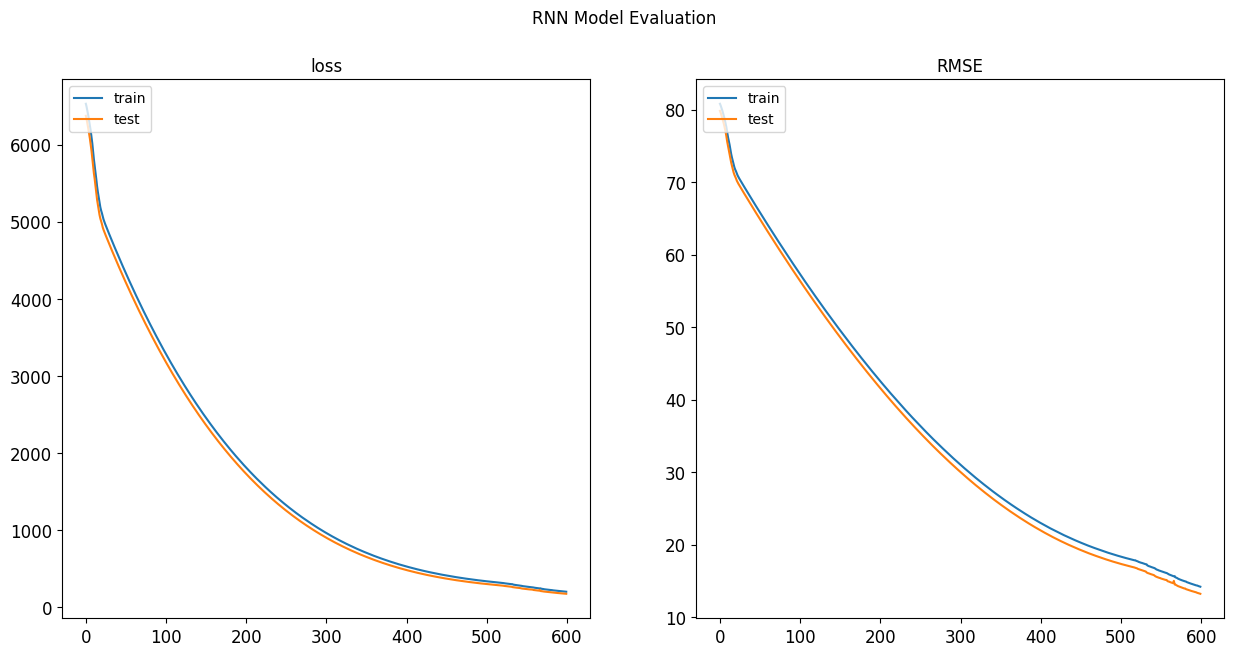

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [21]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


2/2 [==============================] - 0s 12ms/step


13.235565030865137

## Neural Network

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 8ms/step - loss: 13420.8496
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 11603.5049
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 9931.8672
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 8428.7979
Epoch 5/100
3/3 [==============================] - 0s 2ms/step - loss: 7066.5088
Epoch 6/100
3/3 [==============================] - 0s 2ms/step - loss: 5868.6548
Epoch 7/100
3/3 [==============================] - 0s 0s/step - loss: 4798.1558
Epoch 8/100
3/3 [==============================] - 0s 2ms/step - loss: 3893.3430
Epoch 9/100
3/3 [==============================] - 0s 2ms/step - loss: 3096.4751
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 2436.4949
Epoch 11/100
3/3 [==============================] - 0s 2ms/step - loss: 1888.9298
Epoch 12/100
3/3 [==============================] - 0s 2ms/step - loss: 1415.7607
Epoch 13/100
3/3 [======

In [23]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


In [24]:
mean_squared_error(y_test, y_pred)

8.627464024585484

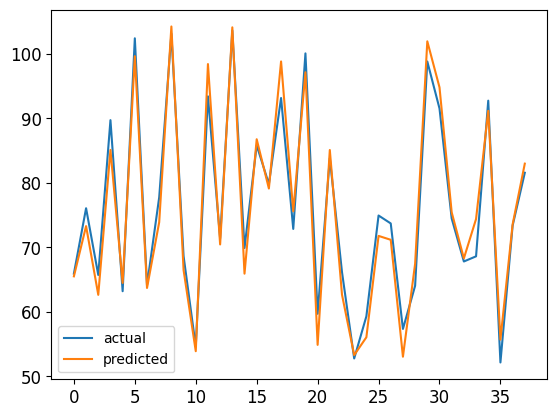

In [25]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## LSTM with one layer

In [26]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 1s 8ms/step - loss: 3763.9155
Epoch 2/30
3/3 [==============================] - 0s 10ms/step - loss: 2520.4941
Epoch 3/30
3/3 [==============================] - 0s 5ms/step - loss: 1353.8490
Epoch 4/30
3/3 [==============================] - 0s 4ms/step - loss: 1099.5005
Epoch 5/30
3/3 [==============================] - 0s 4ms/step - loss: 209.9012
Epoch 6/30
3/3 [==============================] - 0s 4ms/step - loss: 90.2197
Epoch 7/30
3/3 [==============================] - 0s 4ms/step - loss: 149.3986
Epoch 8/30
3/3 [==============================] - 0s 4ms/step - loss: 185.5388
Epoch 9/30
3/3 [==============================] - 0s 2ms/step - loss: 153.8742
Epoch 10/30
3/3 [==============================] - 0s 4ms/step - loss: 99.0770
Epoch 11/30
3/3 [==============================] - 0s 4ms/step - loss: 70.3401
Epoch 12/30
3/3 [==============================] - 0s 4ms/step - loss: 50.4693
Epoch 13/30
3/3 [==============================]

### Predictions

In [28]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 4ms/step


In [29]:
mean_squared_error(y_test, y_pred)

4.547128862775867

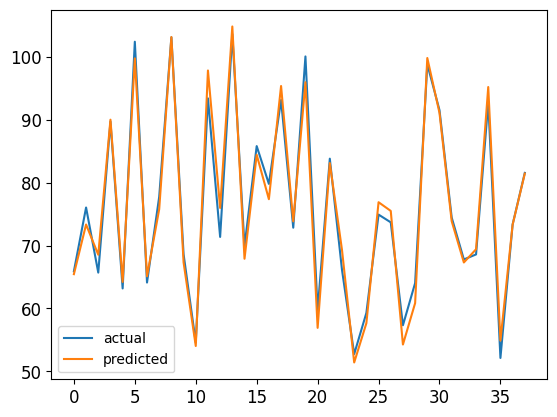

In [30]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## LSTM with more layers

In [31]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 3s 8ms/step - loss: 6165.1421
Epoch 2/30
3/3 [==============================] - 0s 8ms/step - loss: 6132.9736
Epoch 3/30
3/3 [==============================] - 0s 8ms/step - loss: 6100.8809
Epoch 4/30
3/3 [==============================] - 0s 8ms/step - loss: 6066.5630
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 6030.4497
Epoch 6/30
3/3 [==============================] - 0s 10ms/step - loss: 5990.9258
Epoch 7/30
3/3 [==============================] - 0s 8ms/step - loss: 5947.8672
Epoch 8/30
3/3 [==============================] - 0s 10ms/step - loss: 5900.7437
Epoch 9/30
3/3 [==============================] - 0s 8ms/step - loss: 5850.2603
Epoch 10/30
3/3 [==============================] - 0s 8ms/step - loss: 5795.8159
Epoch 11/30
3/3 [==============================] - 0s 8ms/step - loss: 5738.9023
Epoch 12/30
3/3 [==============================] - 0s 10ms/step - loss: 5680.0571
Epoch 13/30
3/3 [=================

### Predictions

In [33]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 5ms/step


In [34]:
mean_squared_error(y_test, y_pred)

4734.88058050561

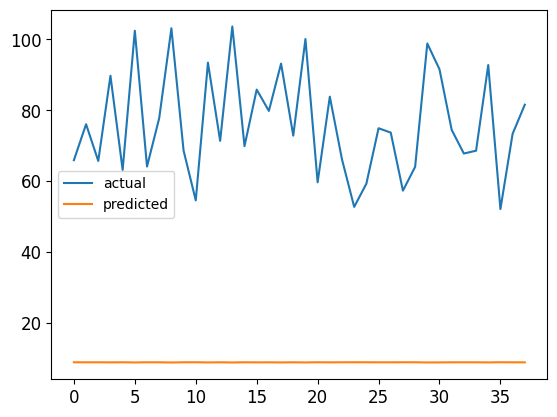

In [35]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## GRU (with more layers)

In [36]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 2s 11ms/step - loss: 5573.5107
Epoch 2/30
3/3 [==============================] - 0s 10ms/step - loss: 5084.7192
Epoch 3/30
3/3 [==============================] - 0s 6ms/step - loss: 4626.7280
Epoch 4/30
3/3 [==============================] - 0s 6ms/step - loss: 4128.7544
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 3408.9346
Epoch 6/30
3/3 [==============================] - 0s 6ms/step - loss: 2855.9907
Epoch 7/30
3/3 [==============================] - 0s 6ms/step - loss: 2352.6194
Epoch 8/30
3/3 [==============================] - 0s 8ms/step - loss: 1776.6025
Epoch 9/30
3/3 [==============================] - 0s 8ms/step - loss: 1268.4352
Epoch 10/30
3/3 [==============================] - 0s 6ms/step - loss: 757.0377
Epoch 11/30
3/3 [==============================] - 0s 8ms/step - loss: 183.6438
Epoch 12/30
3/3 [==============================] - 0s 8ms/step - loss: 16.4359
Epoch 13/30
3/3 [======================

### Predictions

In [38]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 26ms/step


In [39]:
mean_squared_error(y_test, y_pred)

4.350965710092407

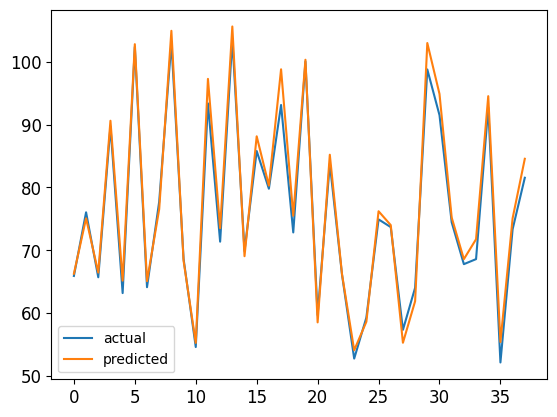

In [40]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 2s 24ms/step - loss: 6044.8096
Epoch 2/30
3/3 [==============================] - 0s 8ms/step - loss: 5705.4683
Epoch 3/30
3/3 [==============================] - 0s 42ms/step - loss: 5431.4668
Epoch 4/30
3/3 [==============================] - 0s 28ms/step - loss: 5137.6455
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 4786.1704
Epoch 6/30
3/3 [==============================] - 0s 7ms/step - loss: 4445.6938
Epoch 7/30
3/3 [==============================] - 0s 10ms/step - loss: 4041.9634
Epoch 8/30
3/3 [==============================] - 0s 8ms/step - loss: 3527.2766
Epoch 9/30
3/3 [==============================] - 0s 24ms/step - loss: 2929.9231
Epoch 10/30
3/3 [==============================] - 0s 24ms/step - loss: 2253.9194
Epoch 11/30
3/3 [==============================] - 0s 24ms/step - loss: 1543.8113
Epoch 12/30
3/3 [==============================] - 0s 6ms/step - loss: 750.0608
Epoch 13/30
3/3 [==============

### Predictions

In [43]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 18ms/step


In [44]:
mean_squared_error(y_test, y_pred)

3.264495673879808

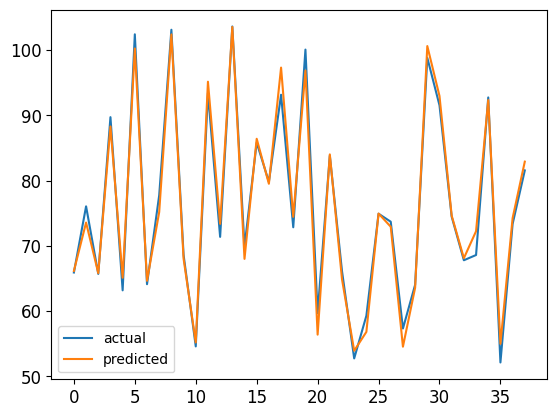

In [45]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

RNN	13.23

NN	8.62

LSTM with One Layer	4.54

LSTM with More Layers	4734.88

GRU( with more layers)	4.35

Conv1D	3.26

Upon comparing the Mean Squared Error values of RNN, NN, LSTM with One Layer, LSTM with More Layers, GRU( with more layers), Conv1D we can observe that Conv1D technique has the lowest Mean Squared Error value 3.26 indicating that is the best performing model